In [3]:
import sys,os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import scipy as sp
from scipy.linalg import pinvh as spinv
from scipy.sparse import csr_matrix,csc_matrix,random
from sklearn.preprocessing import OneHotEncoder as OneHotEncoder
from sklearn.linear_model import lasso_path
import Bio

Code to test sparse inference with FEM

Function to generate sequences for testing. Generate a lot of sequences, then keep only sequences that are more likely `energetically'. Expect that this is more biologically realistic than assuming that all possible sequences are part of the sample space.

In [3]:
def try_1hot():
    n_seq,n_positions,n_residues = 5,5,4
    np.random.seed(7)
    seqs = np.random.randint(0,n_residues,size=(n_seq,n_positions))
    enc = OneHotEncoder(n_values=n_residues)
    onehot = csr_matrix(enc.fit_transform(seqs)).toarray()
    print(onehot)
    onehot = csr_matrix(enc.transform(seqs[:3])).toarray()
    print(onehot)

    onehot = csr_matrix(enc.transform(seqs[3:])).toarray()
    print(onehot)

try_1hot()

[[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]]
[[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]]


In [4]:
def normalize_w(w,n_positions,n_residues):
    n_size = n_residues*n_positions
    wr_1 = np.mean(w.reshape((n_positions,n_residues,n_size)),axis=1) #w(i,A,jB)
    w = (w.reshape((n_positions,n_residues,n_size)) - wr_1[:,np.newaxis,:]).reshape((n_size,n_size)) #w(iA,jB)
    return w
def zero_out(w,index,n_residues):
    w[index*n_residues:(index+1)*n_residues,index*n_residues:(index+1)*n_residues]=0.0
def split_seqs(seqs,index): #remove column i in the sequence 
    return np.copy(np.hstack([seqs[:,:index],seqs[:,index+1:]]))
def split_couplings(w,index,n_residues): #remove row block i in the coupling matrix when we're using only column i
    return np.copy(np.vstack([w[:index*n_residues],w[(index+1)*n_residues:]]))
print(split_couplings(np.arange(24).reshape((6,4)),1,2))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [16 17 18 19]
 [20 21 22 23]]


In [5]:
def nrgy(onehot,w,b):
    nrgy = onehot.multiply(onehot.dot(w) + b).toarray()
#    print(nrgy - np.log(2*np.cosh(nrgy)))
    return np.sum(nrgy - np.log(2*np.cosh(nrgy)),axis=1) #ln prob
    
def generate_sequences(n_residues,n_positions,n_seq):
    n_size = n_residues*n_positions
    n_trial = 10*(n_size) #monte carlo steps to find the right sequences
    res_interactions = np.sign(random(n_positions,n_positions,density=0.3).A)
    res_interactions = np.kron(res_interactions,np.ones((n_residues,n_residues)))
    w = res_interactions*(np.random.rand(n_size,n_size)-0.5)
    b = np.zeros((n_size))
    #different versions of random matrices
#    w = random(n_size,n_size,density=0.3).A -random(n_size,n_size,density=0.3).A
#    w /= np.sqrt(float(n_positions))
#    w = ((np.random.rand(n_size,n_size))-0.5)/np.sqrt(float(n_positions))#(float(n_positions*n_residues))##*float(n_residues))

#    w = (np.random.normal(size=(n_size,n_size)))/(float(n_positions))#*(float(n_positions)))#*float(n_residues))
#    b = (np.random.rand(n_size)-0.5)/float(n_residues)
#    w = w+w.T #symmetric
    for indx in range(n_positions): #no terms W_iA,iB for B != A
        zero_out(w,indx,n_residues)
        #w[indx*n_residues:(indx+1)*n_residues,indx*n_residues:(indx+1)*n_residues]=0.0
#    trial_seq = np.random.randint(0,n_residues,size=(n_seq,n_positions)) #X(s,i)
    trial_seq = np.tile(np.random.randint(0,n_residues,size=(n_positions)),(n_seq,1))
    print(trial_seq[0])
    enc = OneHotEncoder(n_values=n_residues)
    onehot = csr_matrix(enc.fit_transform(trial_seq))
    old_nrgy = nrgy(onehot,w,b) + n_positions*(n_residues-1)*np.log(2)
    for trial in range(n_trial):
#        print('before',np.mean(old_nrgy))
        index_array = np.random.choice(range(n_positions),size=2,replace=False)
        index,index1 = index_array[0],index_array[1]
        r_trial = np.random.randint(0,n_residues,size=(n_seq))

        r_trial1 = np.random.randint(0,n_residues,size=(n_seq))
        
        mod_seq = np.copy(trial_seq)
        mod_seq[:,index] = r_trial

        mod_seq[:,index1] = r_trial1

        mod_nrgy = nrgy(csr_matrix(enc.fit_transform(mod_seq)),w,b) + n_positions*(n_residues-1)*np.log(2)
                
#        if trial%1000==0: print(seq_change)
        seq_change = mod_nrgy-old_nrgy > np.log(np.random.rand(n_seq))
        if trial>n_size:
            trial_seq[seq_change,index] = r_trial[seq_change]
            trial_seq[seq_change,index1] = r_trial1[seq_change]
            old_nrgy[seq_change] = mod_nrgy[seq_change]
        else:
            best_seq = np.argmax(mod_nrgy-old_nrgy)
            trial_seq = np.tile(mod_seq[best_seq],(n_seq,1))
            old_nrgy = np.tile(mod_nrgy[best_seq],(n_seq))

#        
        if trial%n_size == 0: print('after',np.mean(old_nrgy))#,trial_seq[0:5])
#        seqs_i = split_seqs(trial_seq,index)
#        trial_onehot = csr_matrix(enc.fit_transform(seqs_i)) #X(s,\delta_{A_i=A}) seqs,iA
#        w_i = split_couplings(w,index,n_residues)[:,index*n_residues:(index+1)*n_residues]
#        h_trial = (trial_onehot.dot(w_i)+ b[index*n_residues:(index+1)*n_residues])
            #X(s,jB)w(jB,iA) = XW(s,iA)
            #now normalize with the denominator 2 cosh(H_is_i)
#        r_index = trial_seq[:,index]
#        befo =np.sum(w_trial_energy_iA[np.arange(n_seq),r_index])
#        if trial%5000==0: print('before',str(index),befo)
#        w_change = w_trial_energy_iA[np.arange(n_seq),r_trial]-w_trial_energy_iA[np.arange(n_seq),r_index] \
#                        > 5*np.log(np.random.rand(n_seq))
#        later = np.sum(w_trial_energy_iA[np.arange(n_seq)[w_change],r_trial[w_change]])+\
#                np.sum(w_trial_energy_iA[np.arange(n_seq)[~w_change],r_index[~w_change]])
#        if later>befo: 
#            trial_seq[w_change,index] = r_trial[w_change]
#            if trial%5000==0: print('after',trial,index,later)
    print(trial_seq[:10,:10])
    return trial_seq,w,b
np.random.seed(10)
seqs,w_true,b_true = generate_sequences(5,100,20000)

[1 0 0 0 3 4 0 0 2 1 3 2 4 2 2 4 2 0 0 1 2 2 3 4 2 3 0 0 2 0 4 2 2 3 0 3 3
 3 0 3 0 2 4 1 4 2 4 2 3 1 3 3 1 2 2 2 0 3 2 1 2 1 0 2 1 2 1 4 4 0 4 3 1 1
 3 1 3 2 3 4 3 3 3 3 0 1 2 3 2 1 2 1 3 4 0 2 3 2 4 2]
('after', -132.66230665393957)
('after', -9.28770678582373)
('after', -34.44265314650968)
('after', -36.29013862860274)
('after', -36.578735764978035)
('after', -36.62671992011393)
('after', -36.60857842670967)
('after', -36.64262764533186)
('after', -36.61887655815693)
('after', -36.65792558839037)
[[0 0 2 0 1 1 3 4 1 1]
 [0 1 3 4 2 0 4 4 3 0]
 [0 1 3 0 3 0 3 4 0 3]
 [0 4 2 4 4 2 0 1 1 1]
 [0 3 1 0 3 2 4 4 1 2]
 [1 3 0 3 4 3 4 2 0 2]
 [3 4 1 0 3 4 3 1 1 3]
 [0 2 2 3 4 2 2 0 3 0]
 [4 2 0 0 1 2 2 0 4 2]
 [1 4 0 0 2 2 2 4 3 2]]


Now we want to set up the iteration for recovering w_true from the training sequences

First, a function to calculate the correlation function from the 1-hot encoding

In [9]:
def corr(onehot):
    #corr_out = onehot.transpose().dot(onehot).toarray()/np.float(onehot.shape[0])
    corr_out = np.cov(onehot.A,rowvar=False)
    expect = np.array(onehot.mean(axis=0)) #expectation value
    return expect,corr_out# - np.outer(expect,expect) #connected correlation function


In [368]:
def sparse_invert(w,b,eps=1e-6,reps=20,tolerance=1e-2): 
    # return x: wx=b with x of small norm in a cross between l1 and l2
    size = w.shape[1]
    x_old,lambda_x = np.random.rand(size)-0.5,np.diag(np.random.rand(size))
#    print(nplin.norm(w.dot(x_old)-b))
    for rep in range(reps):
        x = (nplin.inv(w.T.dot(w) + eps*lambda_x.T.dot(lambda_x))).dot(w.T.dot(b))
        if np.allclose(x,x_old): break
        if rep==0: var = 0.5*np.std(x)**2
        #var = var/np.sqrt(np.float(rep+1))
        lambda_x = np.power(var/(var+x**2),0.25)
        lambda_x = np.diag(lambda_x)
        x_old = x
#    print(np.median(x),nplin.norm(w.dot(x)-b),nplin.norm(w.dot(x)-b)**2+eps*np.sum(np.abs(x)))
    return spinv(w).dot(b)





In [7]:
def iterate(sequences,w,b,index,res_index,tolerance=1e-6,n_iter=30):
    #w passed in is already missing the index rows
    n_seq,n_pos = sequences.shape
    n_res = w.shape[0]/(n_pos-1)
    sign_iA = - np.ones(n_seq,dtype=np.float)
    which_iA = sequences[:,index] == res_index
    sign_iA[which_iA] = 1.0
    encoder = OneHotEncoder(n_values=n_res)
    seqs = split_seqs(sequences,index)
    onehot = csr_matrix(encoder.fit_transform(seqs)) #leaving out the index position in sequences
    expect_onehot,corr_onehot = corr(onehot)
    discr_old = 1/tolerance
    disc = np.zeros(n_iter)

    h_seq = np.array(b[index*n_pos+res_index]+onehot.dot(w[:])).reshape(n_seq) #h_iA(s) = \sum_jB X_(s,jB).W(jB,iA)
    tanh_h = np.tanh(h_seq)
    hamil_iA = sign_iA*h_seq/tanh_h
    for itera in range(n_iter):
        expect_h = np.array(onehot.transpose().dot(hamil_iA - np.mean(hamil_iA)))/np.float(n_seq) 
        #\sum_s X_(s,jB)*sign_iA*H/tanh(H)(s)
#        evals,evecs=nplin.eigh(corr_onehot)
#        non_zero = np.real(evals) > 1e-12
#        evals=(evals[non_zero])
#        evecs = evecs[:,non_zero]
#        w = np.real(evecs).dot(np.diag(1.0/evals)).dot(evecs.T).dot(expect_h.reshape(w.shape[0]))
        w[:] = spinv(corr_onehot).dot(expect_h.reshape(w.shape[0]))
        b[index*n_pos+res_index] = np.mean(hamil_iA) - expect_onehot.dot(w)
        h_seq = np.array(b[index*n_pos+res_index]+onehot.dot(w)).reshape(n_seq) #h_iA(s) = \sum_jB X_(s,jB).W(jB,iA)
        tanh_h = np.tanh(h_seq)
        hamil_iA = sign_iA*h_seq/tanh_h
        discr = np.mean((sign_iA-tanh_h)**2)
        disc[itera] = discr
#        if np.abs(discr-discr_old)<tolerance: break
        discr_old = discr
    print(index,res_index,itera,discr)
    return disc
def iterate2(target,predictors,var_tol=1e-5,max_iter=30):
    """ Target = +/- 1 for each row of predictors
        Predictors = array of Potts model type states
        Returns (onehot encoding of predictors,w=coupling vector,b=target bias)"""
    which_target = target==+1.0
    n_seq = target.shape[0]
    target_var = np.std(target)
    predictor_var = np.std(predictors,axis=0) #only keep predictors that actually show variation
    active_predictors = predictor_var>var_tol
    encoder = OneHotEncoder()
    onehot = csr_matrix(encoder.fit_transform(predictors[:,active_predictors]))
#    if target_var < var_tol: return (onehot,np.zeros(onehot.shape[1]),n_seq*np.sign(np.mean(target)))
    #don't bother predicting if the target doesn't show any variation
    expect_onehot,corr_onehot = corr(onehot)
    corr_inv = spinv(corr_onehot)
    w_out = np.zeros((max_iter,onehot.shape[1]))
    w,b = np.random.rand(onehot.shape[1])-0.5,np.random.rand()-0.5
    h_seq = np.array(b+onehot.dot(w)).reshape(n_seq) #h_iA(s) = \sum_jB X_(s,jB).W(jB,iA)
    tanh_h = np.tanh(h_seq)
    hamil_iA = target*h_seq/tanh_h
    discr_old = np.mean((target-tanh_h)**2)
    disc = np.zeros(max_iter)
    h_out=[]
    for iter_n in range(max_iter):
        mean_hamil = np.mean(hamil_iA)
        expect_h = np.array(onehot.transpose().dot(hamil_iA - mean_hamil))/np.float(n_seq)    
        w_temp = corr_inv.dot(expect_h.reshape(w.shape[0]))
        b_temp = mean_hamil - expect_onehot.dot(w)
        h_seq = np.array(b_temp+onehot.dot(w_temp)).reshape(n_seq) #h_iA(s) = \sum_jB X_(s,jB).W(jB,iA)
        tanh_h = np.tanh(h_seq)
        hamil_iA = target*h_seq/tanh_h
#        discr = np.mean((target-tanh_h)**2)
        discr = np.mean((-1+tanh_h[which_target])**2)
        disc[iter_n] = discr_old
        w,b = np.copy(w_temp),b_temp
        h_out.append(h_seq)
        discr_old=discr
    h_out = np.array(h_out)
    return disc,h_out,w,b
def iterate3(seqs,w,b,index,eps=1e-2,tolerance=1e-6,n_iter=6):
    #this version works, uses h_BC
    n_seq,n_pos = seqs.shape
    n_res = int(w.shape[0]/(n_pos))
    encoder = OneHotEncoder(n_values=n_res)
    onehot = csr_matrix(encoder.fit_transform(seqs)) 
    target = onehot.A[:,index*n_res:(index+1)*n_res]
    split_seqs0 = split_seqs(seqs,index)
    encoder = OneHotEncoder(n_values=n_res)
    onehot = csr_matrix(encoder.fit_transform(split_seqs0)) 

    
    b_init = np.mean(target,axis=0)
    b_init_zero = b_init > 0.99
    b_init[~b_init_zero] = 0.5/float(n_seq)
    b_init = np.log(b_init/np.sum(b_init))
    b[index*n_res:(index+1)*n_res] = b_init

#     if b_init[b_init_zero].shape[0] > 0:
#         w[:,index*n_res:(index+1)*n_res] = 0.0
#         print(index,' no variation')
#         return np.arange(n_iter),np.zeros(n_iter)

    expect_onehot,corr_onehot = corr(onehot)
    corr_inv = spinv(corr_onehot)
    #print('corr_inv max',np.max(corr_inv))
    disc = np.zeros((n_iter))
    discr_old = 1e12
    for itera in range(n_iter):
        h_seq = np.array(onehot.dot(np.vstack([w[:index*n_res,index*n_res:(index+1)*n_res],\
                                               w[(index+1)*n_res:,index*n_res:(index+1)*n_res]]))).reshape(n_seq,n_res)
        b[index*n_res:(index+1)*n_res] -= np.mean(b[index*n_res:(index+1)*n_res])
        h_seq += b[np.newaxis,index*n_res:(index+1)*n_res]
        #print('h_seq_max',np.max(h_seq))
        exp_h_seq = np.exp(h_seq)
        exp_h_seq /= np.sum(exp_h_seq,axis=1)[:,np.newaxis]
        disc[itera] = np.mean((target-exp_h_seq)**2)
        if itera>2 and disc[itera]>disc[itera-1]:
            w = w_old
            b = b_old
            break
        else:
            w_old = np.copy(w)
            b_old = np.copy(b)
        expect_h = np.mean(h_seq,axis=0)

        for res_index in range(n_res):
            w_temp = np.zeros((n_res*(n_pos-1)))
            for res_index1 in range(n_res):
                if res_index1 != res_index:

                    tgt = target[:,res_index]-target[:,res_index1]
                    which_BC = tgt != 0.0
                    tgt = tgt[which_BC]
                    n_BC = float(tgt.shape[0])
                    if n_BC>0:

                        h_BC = 0.5*(h_seq[which_BC,res_index] - h_seq[which_BC,res_index1])
                        ratio_BsumC = np.zeros(h_BC.shape)

                        expect_h_zero = h_BC != 0.0
                        ratio = 2*np.copy(tgt)
                        ratio[expect_h_zero] *= h_BC[expect_h_zero]/np.tanh(h_BC[expect_h_zero])
                        #print(res_index,res_index1,np.max(ratio))
                        ratio_BsumC += ratio/n_BC #so each sequence which is either B or C counts once
                        w_temp += onehot[which_BC,:].transpose().dot(ratio_BsumC-np.mean(ratio_BsumC))
            w_temp = corr_inv.dot(w_temp)/float(n_res)
            w[:index*n_res,index*n_res+res_index] = w_temp[:index*n_res]

            w[(index+1)*n_res:,index*n_res+res_index] = w_temp[(index)*n_res:]

            w[index*n_res:(index+1)*n_res,index*n_res+res_index] = 0.0

            b[index*n_res+res_index] = expect_h[res_index]#np.mean((ratio_BsumC))
            b[index*n_res+res_index] -= expect_onehot.dot(w_temp)
            
#        print(index,itera,disc[itera])
#        if np.sum(disc[itera-1,:]) < np.sum(disc[itera,:]): break

    return range(itera),disc[:itera]
def iterate4(seqs,w,b,index,eps=1e-2,tolerance=1e-6,n_iter=1000):
    n_seq,n_pos = seqs.shape
    n_res = int(w.shape[0]/(n_pos))
    encoder = OneHotEncoder(n_values=n_res)
    onehot = csr_matrix(encoder.fit_transform(seqs)) 
    target = onehot.A[:,index*n_res:(index+1)*n_res]
    split_seqs0 = split_seqs(seqs,index)
    encoder = OneHotEncoder(n_values=n_res)
    onehot = csr_matrix(encoder.fit_transform(split_seqs0)) 

    
#     b_init = np.mean(target,axis=0)
#     b_init_zero = b_init > 0.99
#     b_init[~b_init_zero] = 0.5/float(n_seq)
#     b_init = np.log(b_init/np.sum(b_init))
#     b[index*n_res:(index+1)*n_res] = b_init

    expect_onehot,corr_onehot = corr(onehot)
    corr_inv = spinv(corr_onehot)
#    print('corr_inv max',np.max(corr_inv))
    disc = np.zeros((n_iter))
    discr_old = 1e12
#    w_temp = np.zeros((n_res*(n_pos-1),n_res))
    w_temp = np.copy(np.vstack([w[:index*n_res,index*n_res:(index+1)*n_res],\
                                w[(index+1)*n_res:,index*n_res:(index+1)*n_res]]))
    w_temp -= np.mean(w_temp,axis=1)[:,np.newaxis]


    for itera in range(n_iter):
        h_seq = np.array(onehot.dot(w_temp)).reshape(n_seq,n_res)
        b[index*n_res:(index+1)*n_res] -= np.mean(b[index*n_res:(index+1)*n_res])[np.newaxis]
        h_seq += b[np.newaxis,index*n_res:(index+1)*n_res]
#        print('h_seq_max',np.max(h_seq))
        exp_h_seq = np.exp(h_seq)
        exp_h_seq /= np.sum(exp_h_seq,axis=1)[:,np.newaxis]
        
        disc[itera] = np.mean((target-exp_h_seq)**2)
        if itera>0 and disc[itera]>disc[itera-1]:
            w = w_old
            b = b_old
            break
        else:
            w_old = np.copy(w)
            b_old = np.copy(b)
        expect_h = np.mean(h_seq,axis=0)
        for indexa in range(n_res):
            n_one = target[:,indexa]==1.0
            tgt = np.copy(target[:,indexa])
            if target[n_one,indexa].shape[0] >0:
                n_ones = float(target[n_one,indexa].shape[0])
                tgt = target[:,indexa]*np.abs(h_seq[:,indexa])*(1-exp_h_seq[:,indexa]) #additive update
                tgt -= np.sum(tgt,axis=0)/n_ones

                w_temp[:,indexa] += corr_inv.dot(onehot.transpose().dot(tgt))/n_ones


#             #multiplicative update
#                 ehs_min = np.min(exp_h_seq[n_one,indexa])
#                 if ehs_min < 1.0/np.e**2:
#                     exp_h_seq_plus = np.power(exp_h_seq[n_one,indexa],-2.0/np.log(ehs_min))
#                 else:
#                     exp_h_seq_plus = exp_h_seq[n_one,indexa]
#                 tgt[n_one] *= np.abs(h_seq[n_one,indexa])/exp_h_seq_plus
#                 tgt[n_one] -= np.sum(tgt[n_one],axis=0)/n_ones
            if target[~n_one,indexa].shape[0] >0:
                n_ones = float(target[~n_one,indexa].shape[0])
                tgt = -(1-target[:,indexa])*np.abs(h_seq[:,indexa])*(exp_h_seq[:,indexa]) #additive update
                tgt -= np.sum(tgt,axis=0)/n_ones

                w_temp[:,indexa] += corr_inv.dot(onehot.transpose().dot(tgt))/n_ones


            #multiplicative update for target =0

#                 ehs_min = np.min(1-exp_h_seq[~n_one,indexa])
#                 if ehs_min < 1.0/np.e**2:
#                     exp_h_seq_plus = np.power(1-exp_h_seq[~n_one,indexa],-2.0/np.log(ehs_min))
#                 else:
#                     exp_h_seq_plus = 1-exp_h_seq[~n_one,indexa]
#                 tgt[~n_one] = -(1-tgt[~n_one])*np.abs(h_seq[~n_one,indexa])/exp_h_seq_plus


#                 tgt[~n_one] -= np.sum(tgt[~n_one],axis=0)/n_ones

#             w_temp[:,indexa] = corr_inv.dot(onehot.transpose().dot(tgt))/float(n_seq)


        w_temp -= np.mean(w_temp,axis=1)[:,np.newaxis]
        b[index*n_res:(index+1)*n_res] = expect_h - expect_onehot.dot(w_temp)
        w[:index*n_res,index*n_res:(index+1)*n_res] = w_temp[:index*n_res,:]

        w[(index+1)*n_res:,index*n_res:(index+1)*n_res] = w_temp[index*n_res:,:]
            
#        print(index,itera,disc[itera])
#        if np.sum(disc[itera-1,:]) < np.sum(disc[itera,:]): break

    return range(itera),disc[:itera]





    

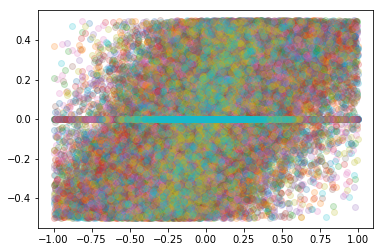

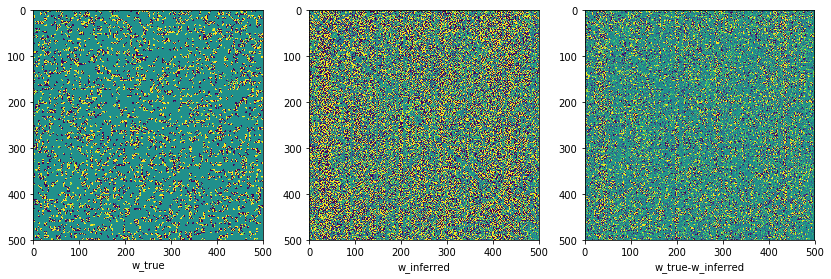

In [10]:
w0 = (np.random.rand(w_true.shape[0],w_true.shape[1])-0.5)#/float(w_true.shape[1])
b0 = np.random.rand(b_true.shape[0])-0.5
max_iter=60
n_seq,n_pos = seqs.shape
n_res = w0.shape[0]/n_pos

for index in range(n_pos):
    rang,disc = iterate3(seqs[:20000],w0,b0,index)
    w_tr_nonzero = np.abs(w_true[:,index*n_res:(index+1)*n_res]) <1

    w_nonzero = np.abs(w0[:,index*n_res:(index+1)*n_res]) <1

    w_true_nonzero = np.logical_and(w_tr_nonzero,w_nonzero)
    plt.plot((w0[:,index*n_res:(index+1)*n_res])[w_true_nonzero],(w_true)[:,index*n_res:(index+1)*n_res][w_true_nonzero],'o',alpha = 0.2)
#    plt.plot(range(max_iter),dis[index])
#    plt.plot(rang,disc,'-',alpha = 0.2)
plt.show()
plt.close()

fig, (ax1, ax2,ax3) = plt.subplots(1,3)
# make a little extra space between the subplots
fig.set_size_inches(14,44)
fig.subplots_adjust(hspace=0.5)

ax1.imshow(w_true, vmin=-.2,vmax=0.2)
ax1.set_xlabel('w_true')

ax2.imshow(w0,vmin=-.2,vmax=0.2)
ax2.set_xlabel('w_inferred')

ax3.imshow(w_true-w0,vmin=-.4,vmax=0.4)
ax3.set_xlabel('w_true-w_inferred')

#    plt.plot(w0[:,index*n_res:(index+1)*n_res][w_true_nonzero],w_true[:,index*n_res:(index+1)*n_res][w_true_nonzero],'o',alpha = 0.2)
#    plt.plot(range(max_iter),dis[index])
#    plt.plot(rang,disc,'-',alpha = 0.2)
plt.show()
plt.close()

#        w_trial = split_couplings(w0,index,n_res)[:,n_res*index+res_index]
#        disc = iterate(seqs,w_trial,b0,index,res_index)
#        reinsert(w0,w_trial,index,res_index)
#        plt.plot(w0[:,n_res*index+res_index],w_true[:,n_res*index+res_index],'bo')
#        plt.show()
#        plt.close()

#        plt.plot(range(10),w_true[index*n_res+res_index+1:index*n_res+res_index+11,index*n_res+res_index],'r^')
#        plt.plot(range(10),w_trial[index*n_res+res_index+1:index*n_res+res_index+11,index*n_res+res_index],'bo')
#        plt.show()
#        plt.close()